In [2]:
# Standard library imports
import os
import time
import warnings
import random
import glob
import pickle
from pathlib import Path
from typing import Tuple, Dict, List

# Third-party imports
import numpy as np
import pandas as pd
import requests
import zipfile
import cv2
from PIL import Image
from skimage import io, transform

# Data visualization
import matplotlib.pyplot as plt
plt.ion()  # interactive mode

# PyTorch imports
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms, utils
from torchsummary import summary

# Ignore warnings
warnings.filterwarnings("ignore")

In [5]:
def load_pickle_image(file_path):
    with open(file_path, "rb") as f:         
        return pickle.load(f)                 

# Load all .pck files
file_paths = []                              
for vol in range(1, 9):                      
    folder = f"archive/vol{vol:02d}"         
    file_paths += sorted(glob.glob(f"{folder}/*.pck"))  

images = [load_pickle_image(p) for p in file_paths]  

archive/vol01 directory exists.


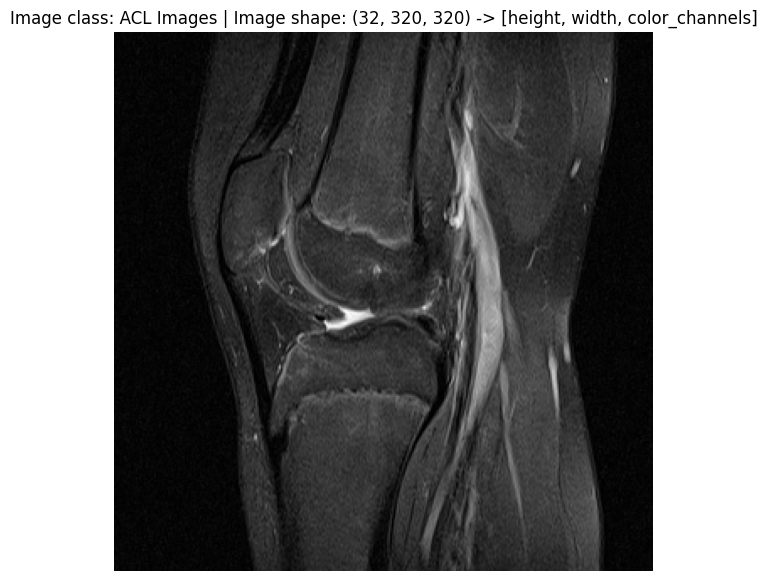

In [6]:
# Setup path to data folder
data_path = Path("archive/")
image_path = data_path / "vol01"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(glob.glob(f"{folder}/*.pck"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = "ACL Images"

# 4. Open image
img = load_pickle_image(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array[16], cmap='gray')
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


In [7]:
# Setup path for target directory and testing paths
data = pd.read_csv("metadata.csv")           
train_dir = data_path / "vol1"              
test_dir = data_path / "vol2"               

unique_classes = sorted(data['aclDiagnosis'].unique())  # Get all unique diagnosis classes
class_to_idx = {0: 0, 1: 1, 2: 2}           # Map class values to indices (0: Normal, 1: Torn, 2: Partially torn)
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}  # Create reverse mapping

In [8]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = self.paths = list(glob.glob(f"{image_paths}/*.pck"))  # Get list of all .pck files in directory
        self.transform = transform           # Store transform function for later use

    def __len__(self):
        return len(self.image_paths)        # Return total number of images in dataset

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]  # Get path of requested image
        img = load_pickle_image(image_filepath) # Load the image from pickle file

        # label = image_filepath.split('/')[-2]
        label = self.image_paths[idx].parent.name  # Get label from parent directory name

        label = class_to_idx[label]        # Convert text label to numerical index
        if self.transform is not None:
            image = self.transform(image)   

        return image, label                

In [9]:
# Create dataset instances for training and testing
train_data_custom = CustomDataset(
    image_paths = "archive/vol01",          
    transform = None)                       
test_data_custom = CustomDataset(
    image_paths = "archive/vol02",          
    transform = None)                      

In [10]:
# Print the size of training and testing datasets
len(train_data_custom), len(test_data_custom)  # Returns (number of training samples, number of test samples)

(92, 92)

In [11]:
# Create DataLoader for training data
train_dataloader_custom = DataLoader(
    dataset=train_data_custom,      
    batch_size=4,                   # Process 4 images at a time
    num_workers=0,                  # Don't use multiple processes for loading (0 means only main process)
    shuffle=True)                   

# Create DataLoader for testing data
test_dataloader_custom = DataLoader(
    dataset=test_data_custom,       
    batch_size=4,                   
    num_workers=0,                  
    shuffle=False)                  